In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# sklearn imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KDTree

# sklearn models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [50]:
path = '../data/modified/trees_first.pkl'
trees= pd.read_pickle(path)

In [51]:
trees = trees.astype({'ADR_SECTEUR':'object'})

trees_train,trees_test = train_test_split(trees,random_state=2708)

In [52]:
trees_train

,ELEM_POINT_ID,CODE,NOM,GENRE,GENRE_DESC,CATEGORIE,CATEGORIE_DESC,SOUS_CATEGORIE,SOUS_CATEGORIE_DESC,CODE_PARENT,...,COURRIER,IDENTIFIANTPLU,TYPEIMPLANTATIONPLU,INTITULEPROTECTIONPLU,ANNEEABATTAGE,ESSOUCHEMENT,DIAMETREARBRE,CAUSEABATTAGE,COLLECTIVITE,GeoJSON
9601,5806,ESP11188,ESP11188,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7061954595516..."
1784,4335,ESP27118,ESP27118,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grenoble Alpes Métropole,"{""type"":""Point"",""coordinates"":[5.7292179183578..."
12932,7913,ESP14044,ESP14044,VEG,VEGETATION,ESP01,Arbre,ESP065,Arbre d'enceintes fermées,ESP278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7446258071375..."
17720,10166,ESP20355,ESP20355,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7058888909579..."
19655,9497,ESP21047,ESP21047,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7417478660735..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,5107,ESP27079,ESP27079,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7362331284116..."
9389,7415,ESP10582,ESP10582,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7318407698686..."
17367,12537,ESP19250,ESP19250,VEG,VEGETATION,ESP01,Arbre,ESP151,Arbre de voirie,ESP1335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grenoble Alpes Métropole,"{""type"":""Point"",""coordinates"":[5.7131571600355..."
18855,31825,ESP32587,ESP32587,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7374681761772..."


# Transform data

## Preprocessing

In [53]:
# Transforme GEOJSON data in two features
class TransformGEOJSON(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df,y=None):
        return self
    def transform(self, df):
        df_new = df.copy()
        pat = '([0-9]+.[0-9]+)'
        df_new[['latitude','longitude']] = df_new.GeoJSON.str.extractall(pat).unstack(level=1).astype('float64')
        df_new = df_new.drop('GeoJSON',axis=1)
        return df_new

# Drop features without info (1) or identifiers features
class DropuniqueCol(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        to_drop = ['ELEM_POINT_ID','CODE','NOM','GENRE','GENRE_DESC','CATEGORIE','CATEGORIE_DESC','BIEN_REFERENCE','SOUS_CATEGORIE','CODE_PARENT']
        df_new = df.drop(to_drop,axis=1)
        return df_new

# Drop Na features     
class DropNaWithSaveCol(BaseEstimator,TransformerMixin):
    def __init__(self,na_threshold=0.5):
        self.threshold = na_threshold
    def fit(self, df):
        na = df.isna().sum().div(len(df)).sort_values(ascending=False)
        self.col_na = na.where(na>=self.threshold).dropna().index
        return self
    def transform(self, df):
        check_is_fitted(self, ['col_na'])
        df_new= df.drop(self.col_na,axis=1)
        return df_new

## Creating simple custom imputer

In [54]:
class InputMissingValues(BaseEstimator,TransformerMixin):
    
    def __init__(self,to_use=True):
        self.to_use=to_use
        self.errors = []
        
    def fit(self, df,y=None):
        self.most_freq_genre = df.GENRE_BOTA.mode().values[0]
        self.gerne_espece = df.groupby('GENRE_BOTA').ESPECE.value_counts(dropna=False).sort_values(ascending=False)
        self.fill_with = 'ND'
        self.errors = []
        return self
    
    def transform(self, df):
        if self.to_use:
            df_new = df.copy()
            df_new['COLLECTIVITE'] = df_new['COLLECTIVITE'].fillna(self.fill_with)
            df_new['STADEDEDEVELOPPEMENT'] = df_new['STADEDEDEVELOPPEMENT'].fillna(self.fill_with)
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].fillna(self.most_freq_genre)
            
            liste_ind = []
            liste_replace = []
            
            for ind,row in df_new.iterrows():
                if isinstance(row['ESPECE'], float):
                    liste_ind.append(ind)
                    genre = row['GENRE_BOTA']
                    if genre == 'Poncinos':
                        self.errors.append((ind,row))
                    # check database for most common species accociated with gern
                    species_replace = self.gerne_espece.xs(genre,level=0).idxmax()
                    if isinstance(species_replace, float):
                        species_replace = self.fill_with
                    liste_replace.append(species_replace)
            if len(liste_ind) != 0:
                for ind,replace in zip(liste_ind,liste_replace):
                    df_new.loc[ind,'ESPECE'] = replace
            return  df_new
        else:
            return df

## Preprocess pipeline

In [55]:
preprocess_pipeline = Pipeline([("geo", TransformGEOJSON()),
                                ('dropuni',DropuniqueCol()),
                                ('na',DropNaWithSaveCol()),
                               ('fillna',InputMissingValues())])

## Feature add

In [56]:
# Create Bio features

class Bio(BaseEstimator,TransformerMixin):
    def __init__(self,to_use=True):
        self.to_use = to_use
    def fit(self, df,y=None):
        return self
    def transform(self,df):
        if self.to_use:
            df_new = df.copy()
            df_new['ESPECE'] = df_new['ESPECE'].map(str).replace('nan',' ')
            df_new['GENRE_BOTA'] = df_new['GENRE_BOTA'].map(str).replace('nan',' ')
            df_new['BIO'] = df_new['GENRE_BOTA'] + " " + df['ESPECE']
            df_new = df_new.drop(['GENRE_BOTA','ESPECE'],axis=1)
            return df_new
        else:
            return df

feature_adder = Pipeline(['Bio',Bio()])

## Columns Transformer 

In [57]:
categorical_transformer = OneHotEncoder(handle_unknown ='infrequent_if_exist')
numerical_transformer = StandardScaler()

transformer = ColumnTransformer(
[("num_trans", numerical_transformer, make_column_selector(dtype_exclude="object")),
("cat_trans", categorical_transformer, make_column_selector(dtype_include='object'))])

## Transform Train

In [58]:
predictor_train = trees_train.drop('ANNEEDEPLANTATION',axis=1)

In [59]:
annee_train = trees_train.ANNEEDEPLANTATION

In [60]:
processed_train_predictors = preprocess_pipeline.fit_transform(predictor_train)
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [61]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC     0
CODE_PARENT_DESC        0
ADR_SECTEUR             0
GENRE_BOTA              0
ESPECE                  0
STADEDEDEVELOPPEMENT    0
COLLECTIVITE            0
latitude                0
longitude               0
dtype: int64

# Modelisation

In [88]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[False,True],
           'model__n_estimators':[10],
           'model':[model_1]} 
model_2 = DecisionTreeRegressor()
param_2 = {'f_adder_1__to_use':[False,True],
           'model__min_samples_leaf':[1],
           'model':[model_2]} 
model_3 = SVR()
param_3 = {'f_adder_1__to_use':[False,True],
           'model__C':[10],
           'model':[model_3]} 
model_4 = LinearRegression()
param_4 = {'f_adder_1__to_use':[False,True],
           'model':[model_4]} 
model_5 = Lasso()
param_5 = {'f_adder_1__to_use':[True],
           'model__alpha':[10],
           'model':[model_5]} 

In [89]:
pipe = Pipeline(steps=[('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])
params_list = [param_1,param_2,param_3,param_4,param_5]

grid_search = GridSearchCV(pipe,params_list,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [90]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__n_estimators,param_model__min_samples_leaf,param_model__C,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,5.924662,0.112261,0.040404,0.003061,True,RandomForestRegressor(n_estimators=10),10,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': RandomFor...",-34.081130,-30.466147,-32.975072,-38.671258,-35.721765,-34.383074,2.742137,1
0,6.774923,0.218686,0.046382,0.024756,False,RandomForestRegressor(n_estimators=10),10,NaN,NaN,NaN,"{'f_adder_1__to_use': False, 'model': RandomFo...",-35.964580,-30.655636,-32.197885,-38.110042,-35.182660,-34.422161,2.671778,2
3,0.866900,0.067274,0.032522,0.004338,True,DecisionTreeRegressor(),NaN,1,NaN,NaN,"{'f_adder_1__to_use': True, 'model': DecisionT...",-43.205993,-43.738489,-45.706103,-51.934993,-51.095416,-47.136199,3.680760,3
4,33.237258,0.319564,3.832494,0.069892,False,SVR(),NaN,NaN,10,NaN,"{'f_adder_1__to_use': False, 'model': SVR(), '...",-46.868589,-43.853723,-49.081666,-49.940022,-51.322713,-48.213343,2.616036,4
2,0.917082,0.093254,0.027221,0.002854,False,DecisionTreeRegressor(),NaN,1,NaN,NaN,"{'f_adder_1__to_use': False, 'model': Decision...",-44.249394,-45.161489,-46.866711,-55.437197,-51.905685,-48.724095,4.274418,5
5,27.119133,4.557884,2.831966,0.761902,True,SVR(),NaN,NaN,10,NaN,"{'f_adder_1__to_use': True, 'model': SVR(), 'm...",-48.292738,-44.424818,-51.211568,-51.600671,-53.154758,-49.736911,3.086547,6
7,1.034758,0.183467,0.028973,0.007986,True,LinearRegression(),NaN,NaN,NaN,NaN,"{'f_adder_1__to_use': True, 'model': LinearReg...",-59.762649,-57.711563,-54.510774,-62.386058,-57.453062,-58.364821,2.616716,7
6,2.504481,0.131388,0.031963,0.001819,False,LinearRegression(),NaN,NaN,NaN,NaN,"{'f_adder_1__to_use': False, 'model': LinearRe...",-60.474717,-57.893316,-55.415513,-62.270453,-57.881462,-58.787092,2.365097,8
8,0.151408,0.015598,0.029904,0.005801,True,Lasso(),NaN,NaN,NaN,10,"{'f_adder_1__to_use': True, 'model': Lasso(), ...",-312.989950,-319.720947,-317.132212,-321.213498,-320.278011,-318.266924,2.965636,9


In [91]:
best_pipe = grid_search.best_estimator_

In [92]:
best_pipe

Pipeline(steps=[('f_adder_1', Bio()),
                ('transformer',
                 ColumnTransformer(transformers=[('num_trans', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fac8ada5b50>),
                                                 ('cat_trans',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fac8ada5d00>)])),
                ('model', RandomForestRegressor(n_estimators=10))])

In [93]:
best_pipe.score(processed_train_predictors,annee_train)

0.9826836381285864

## Check parameters of the forest => tree depth, max features

In [94]:
liste_depth=[]
for estimator in best_pipe.named_steps['model'].estimators_:
    liste_depth.append(estimator.get_depth())

In [95]:
liste_max_features=[]
for estimator in best_pipe.named_steps['model'].estimators_:
    liste_max_features.append(estimator.max_features_)

In [96]:
print(f'Mean depth : {sum(liste_depth)/len(liste_depth)}')
print(f'Mean Max Features : {sum(liste_max_features)/len(liste_max_features)}')

Mean depth : 93.9
Mean Max Features : 1789.0


# Test of best model on test dataset

In [76]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [77]:
process_test_predictors = preprocess_pipeline.transform(test_predictors)

In [78]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

31.66627230667547

In [79]:
best_pipe.score(process_test_predictors,annee_test)

0.9019317584249809

# Prediction on na values

In [80]:
path_first_na = '../data/modified/trees_first_na.pkl'
trees_na= pd.read_pickle(path_first_na)

In [81]:
trees_na

,ELEM_POINT_ID,CODE,NOM,GENRE,GENRE_DESC,CATEGORIE,CATEGORIE_DESC,SOUS_CATEGORIE,SOUS_CATEGORIE_DESC,CODE_PARENT,...,COURRIER,IDENTIFIANTPLU,TYPEIMPLANTATIONPLU,INTITULEPROTECTIONPLU,ANNEEABATTAGE,ESSOUCHEMENT,DIAMETREARBRE,CAUSEABATTAGE,COLLECTIVITE,GeoJSON
1075,39588,ESP38596,ESP38596,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7033870348283..."
1076,39589,ESP38597,ESP38597,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7034657665144..."
1077,39590,ESP38598,ESP38598,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7199743332099..."
1088,43402,ESP39987,ESP39987,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7139485923092..."
1089,43403,ESP39988,ESP39988,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ville de Grenoble,"{""type"":""Point"",""coordinates"":[5.7138453760140..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31603,46019,ESP41553,ESP41553,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7358259784285..."
31604,46020,ESP41554,ESP41554,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7356836831762..."
31605,46021,ESP41555,ESP41555,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7362096829728..."
31606,46022,ESP41556,ESP41556,VEG,VEGETATION,ESP01,Arbre,ESP174,Arbre d'espaces ouverts,ESP1034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[5.7355397923023..."


In [82]:
trees_na = trees_na.astype({'ADR_SECTEUR':'object'})

In [83]:
trees_na = trees_na.drop(['ANNEEDEPLANTATION'],axis=1)

In [84]:
processed_na = preprocess_pipeline.transform(trees_na)

In [85]:
processed_na

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
1075,Arbre d'espaces ouverts,Ch 3 maisonsi th de création,1,Zelkova,serrata,Arbre adulte,Ville de Grenoble,5.703387,45.189097
1076,Arbre d'espaces ouverts,Ch 3 maisonsi th de création,1,Zelkova,serrata,Arbre adulte,Ville de Grenoble,5.703466,45.189104
1077,Arbre d'espaces ouverts,Jard des Dauphins le labo,2,Maclura,pomifera,Arbre adulte,Ville de Grenoble,5.719974,45.194390
1088,Arbre d'espaces ouverts,Parc Paul Valérien Perrin,1,Acer,pseudoplatanus,Arbre jeune,Ville de Grenoble,5.713949,45.182986
1089,Arbre d'espaces ouverts,Parc Paul Valérien Perrin,1,Acer,pseudoplatanus,Arbre jeune,Ville de Grenoble,5.713845,45.183063
...,...,...,...,...,...,...,...,...,...
31603,Arbre d'espaces ouverts,Parc 2 R Herminier centre,2,Acer,pseudoplatanus,ND,ND,5.735826,45.195394
31604,Arbre d'espaces ouverts,Parc 2 R Herminier centre,2,Acer,pseudoplatanus,ND,ND,5.735684,45.195362
31605,Arbre d'espaces ouverts,Parc 2 R Herminier ch de Ronde,2,Acer,pseudoplatanus,ND,ND,5.736210,45.195236
31606,Arbre d'espaces ouverts,Parc 2 R Hermin M Leclerq,2,Acer,pseudoplatanus,ND,ND,5.735540,45.195325


In [86]:
y = best_pipe.predict(processed_na)

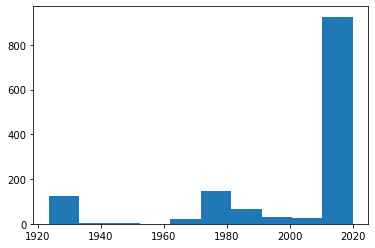

In [87]:
plt.hist(y);

# Hyperparameter tuning for random forest regressor

## Hyperparameter tuning

### Tuning 1

In [35]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,50,100],
           'model__min_samples_leaf':[1,10,20],
           'model':[model_1]} 

In [36]:
pipe = Pipeline(steps=[('custom_simple_imputer',InputMissingValues(False)),
                       ('f_adder_1',Bio()),
                       ('transformer',transformer),
                       ("model",model_1)])

In [37]:
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [38]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,64.938616,0.822484,0.076373,0.001641,True,RandomForestRegressor(),1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-25.029898,...,-27.926327,-32.394799,-26.858677,-26.803894,-41.364380,-32.344670,-31.305481,-30.627975,4.751544,1
1,31.845910,0.285212,0.048015,0.000605,True,RandomForestRegressor(),1,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-25.336042,...,-27.699264,-32.648112,-27.165709,-25.307440,-42.552765,-32.897990,-32.533741,-31.050508,5.040703,2
0,6.440272,0.075691,0.026863,0.001858,True,RandomForestRegressor(),1,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-28.400670,...,-29.820220,-35.042261,-28.877069,-30.022534,-42.266509,-33.890150,-33.817752,-33.175517,4.145284,3
5,32.433320,0.195417,0.061243,0.002336,True,RandomForestRegressor(),10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-48.134604,...,-50.802589,-56.937403,-50.848554,-51.606761,-57.032883,-56.849494,-57.138045,-54.642520,3.900071,4
4,16.253235,0.086530,0.040233,0.000328,True,RandomForestRegressor(),10,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-47.786476,...,-51.063559,-56.583094,-50.802055,-52.434763,-57.509963,-56.713258,-56.597546,-54.660219,3.884119,5
3,3.312085,0.015782,0.023708,0.000180,True,RandomForestRegressor(),10,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-50.407676,...,-52.977264,-58.782128,-54.212426,-54.156593,-59.487628,-58.920049,-58.008897,-56.805398,4.316315,6
7,12.393924,0.078940,0.037175,0.000448,True,RandomForestRegressor(),20,50,"{'f_adder_1__to_use': True, 'model': RandomFor...",-65.797450,...,-69.341827,-74.729504,-68.364561,-69.343363,-74.337654,-76.823504,-79.852407,-72.949576,4.457429,7
8,23.309492,2.646667,0.045603,0.008619,True,RandomForestRegressor(),20,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",-65.283184,...,-69.304616,-75.170273,-69.997739,-68.869192,-72.786992,-76.653829,-80.051006,-73.028011,4.647871,8
6,2.543986,0.019601,0.023449,0.000284,True,RandomForestRegressor(),20,10,"{'f_adder_1__to_use': True, 'model': RandomFor...",-66.214637,...,-71.063425,-77.262551,-71.974715,-71.599491,-76.117402,-77.979941,-79.199064,-74.975703,4.427940,9


### Tuning 2

In [39]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,50],
           'model__min_samples_leaf':[1,10,25],
           'model__max_features':['sqrt','log2'],
           'model__ccp_alpha':[0,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]

grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [40]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [41]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.741594,0.058265,0.042637,0.004443,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,1,25,...,-28.574748,-30.836236,-26.476672,-23.964746,-35.525286,-28.765543,-29.135191,-27.712358,3.906650,9
1,7.315560,0.066059,0.061726,0.003048,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,1,50,...,-26.961957,-29.381247,-24.682354,-24.032484,-34.366098,-25.807635,-29.056398,-26.865153,3.382348,3
2,0.374167,0.012264,0.027630,0.000316,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,10,25,...,-137.117679,-156.056315,-135.009075,-143.884148,-154.308223,-142.336928,-142.060037,-144.886389,8.755204,19
3,0.632943,0.009740,0.034732,0.000408,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,10,50,...,-133.986766,-155.032528,-137.195552,-144.739965,-149.161232,-155.680406,-144.304941,-145.530430,7.219595,20
4,0.232283,0.010045,0.026181,0.000979,True,"RandomForestRegressor(ccp_alpha=0.001, max_fea...",0,sqrt,25,25,...,-216.803145,-229.828503,-194.467947,-208.922034,-210.436877,-223.723410,-211.477201,-212.078175,11.530912,31


In [42]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
19,-26.656152,50,0.001,1,log2
13,-26.756285,50,0.001,1,sqrt
1,-26.865153,50,0,1,sqrt
7,-26.915276,50,0,1,log2
12,-27.434352,25,0.001,1,sqrt
31,-27.577181,50,0.01,1,log2
6,-27.665536,25,0,1,log2
18,-27.703115,25,0.001,1,log2
0,-27.712358,25,0,1,sqrt
24,-28.229070,25,0.01,1,sqrt


### Tuning 3

In [43]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[25,100,150],
           'model__min_samples_leaf':[1,2,3,4,5],
           'model__max_features':['sqrt'],
           'model__ccp_alpha':[0,0.0001,0.001,0.01,0.1],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [44]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [45]:
grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.718083,0.047271,0.045632,0.006286,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,25,...,-27.763365,-31.415162,-25.985464,-25.301484,-34.848190,-26.836908,-28.997703,-27.726933,3.237857,11
1,15.242559,0.282303,0.114349,0.020716,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,100,...,-26.285801,-27.965281,-24.481670,-23.341937,-33.993339,-25.707915,-28.197776,-26.261168,3.379732,3
2,22.014629,0.081270,0.142405,0.002357,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,1,150,...,-25.524111,-28.668448,-23.556472,-23.005459,-32.849404,-25.829542,-27.383661,-25.954085,3.249631,1
3,1.135457,0.026388,0.032706,0.000281,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,25,...,-70.417883,-78.138661,-71.819566,-70.271797,-80.714900,-74.659690,-71.033773,-73.707673,4.283376,25
4,4.228250,0.025054,0.068546,0.001076,True,"RandomForestRegressor(ccp_alpha=0, max_feature...",0,sqrt,2,100,...,-67.009413,-78.909914,-67.604859,-70.257266,-80.844541,-73.162843,-70.634688,-72.472587,5.115885,23


In [46]:
grid_results.sort_values(by='rank_test_score')[['mean_test_score','param_model__n_estimators','param_model__ccp_alpha','param_model__min_samples_leaf','param_model__max_features']].head(20)

,mean_test_score,param_model__n_estimators,param_model__ccp_alpha,param_model__min_samples_leaf,param_model__max_features
2,-25.954085,150,0,1,sqrt
17,-26.174886,150,0.0001,1,sqrt
1,-26.261168,100,0,1,sqrt
31,-26.300115,100,0.001,1,sqrt
16,-26.333646,100,0.0001,1,sqrt
32,-26.388813,150,0.001,1,sqrt
47,-27.404473,150,0.01,1,sqrt
46,-27.406498,100,0.01,1,sqrt
30,-27.484406,25,0.001,1,sqrt
15,-27.709270,25,0.0001,1,sqrt


### Tuning 4 Pruning the tree 

Fixing min sample leaf > 1 and limiting the depth of the tree 

In [41]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[100,150,250],
           'model__min_samples_leaf':[5,10],
           'model__max_features':['sqrt'],
           'model__ccp_alpha':[0,0.0001,0.001,0.01,0.1],
           'model__max_depth':[100,125,150],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [42]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [43]:
grid_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
37,3.039318,0.060811,0.081137,0.006150,True,"RandomForestRegressor(ccp_alpha=0.001, max_dep...",0.001,100,sqrt,5,...,-102.745231,-115.623537,-101.077278,-105.677890,-117.164908,-109.945476,-105.115208,-108.691596,6.589530,1
7,2.961977,0.094642,0.082659,0.006758,True,"RandomForestRegressor(ccp_alpha=0.001, max_dep...",0,125,sqrt,5,...,-102.688204,-116.699887,-102.672525,-105.139435,-116.317523,-112.205688,-105.735406,-108.824143,6.436647,2
8,5.205168,0.229853,0.123572,0.010242,True,"RandomForestRegressor(ccp_alpha=0.001, max_dep...",0,125,sqrt,5,...,-101.881741,-115.404971,-103.315646,-105.984811,-117.081667,-111.625806,-105.575703,-108.947798,6.338575,3
50,4.983312,0.151067,0.116504,0.002830,True,"RandomForestRegressor(ccp_alpha=0.001, max_dep...",0.001,150,sqrt,5,...,-100.995613,-116.529167,-103.416207,-106.714396,-117.904671,-110.177880,-106.826405,-108.951735,6.444900,4
61,3.674525,0.327352,0.095165,0.013994,True,"RandomForestRegressor(ccp_alpha=0.001, max_dep...",0.01,125,sqrt,5,...,-101.699707,-116.224309,-102.442342,-107.584407,-117.339265,-110.376398,-106.207086,-108.962744,6.443173,5


### Tuning 5 Reducing the number of features

In [44]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[100],
           'model__max_features':[1700,500,200,100,60,20],
           'model__min_samples_leaf':[1,10,20],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [45]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

In [46]:
grid_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_f_adder_1__to_use,param_model,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
15,14.173775,1.205661,0.114314,0.028905,True,RandomForestRegressor(max_features=20),20,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-26.270622,-28.560269,-23.223652,-23.078857,-33.924182,-25.948054,-27.660559,-26.213208,3.397608,1
12,15.044368,0.419292,0.095977,0.001986,True,RandomForestRegressor(max_features=20),60,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-25.390583,-28.801405,-23.807833,-23.327562,-34.170269,-26.218126,-27.184479,-26.245895,3.477239,2
9,15.782028,0.405776,0.097669,0.005389,True,RandomForestRegressor(max_features=20),100,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-26.261574,-29.105084,-24.871653,-23.962967,-33.185396,-26.458985,-27.714249,-26.517493,3.262123,3
6,17.210585,0.186558,0.087823,0.006174,True,RandomForestRegressor(max_features=20),200,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-25.902620,-29.979952,-24.421540,-23.670841,-34.508785,-28.219312,-27.981362,-26.955449,3.588265,4
3,26.892186,0.886798,0.081834,0.004355,True,RandomForestRegressor(max_features=20),500,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-26.774298,-31.006476,-24.912526,-24.222567,-35.626625,-29.644685,-28.791220,-27.876046,3.887770,5
0,65.342775,0.511935,0.077775,0.005490,True,RandomForestRegressor(max_features=20),1700,1,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-27.925115,-32.385019,-26.293348,-26.720077,-41.524592,-31.802135,-31.398133,-30.548790,4.712463,6
1,32.880716,0.930721,0.066196,0.005437,True,RandomForestRegressor(max_features=20),1700,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-49.757986,-55.913438,-50.451953,-51.830266,-57.619114,-56.597837,-56.411358,-54.216323,4.157213,7
4,12.192289,0.328912,0.061156,0.003951,True,RandomForestRegressor(max_features=20),500,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-56.182776,-64.971683,-57.720870,-58.635616,-67.786009,-63.970311,-62.614521,-61.116271,4.427103,8
2,27.382136,0.996837,0.064019,0.016216,True,RandomForestRegressor(max_features=20),1700,20,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-69.098980,-75.253964,-69.241585,-68.623885,-73.366458,-75.805192,-78.299132,-72.248396,4.229689,9
7,5.206435,0.202523,0.055413,0.003488,True,RandomForestRegressor(max_features=20),200,10,100,"{'f_adder_1__to_use': True, 'model': RandomFor...",...,-74.975656,-87.123717,-76.546372,-79.222724,-86.354349,-84.772735,-78.794644,-81.000368,5.331755,10


### Tuning 6 

In [47]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,25,50,100,150],
           'model__max_features':[500,250,100,60,20,10,5],
           'model__min_samples_leaf':[1,2,5],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [48]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

KeyboardInterrupt: 

In [ ]:
grid_results.sort_values(by='rank_test_score').head()

In [ ]:
df_plot = grid_results[grid_results.param_model__min_samples_leaf==1]

In [ ]:
dic = {
    'param_model__max_features':'int64',
    'param_model__n_estimators':'int64'}
df_plot = df_plot.astype(dic)

In [ ]:
x = df_plot.param_model__max_features
y = df_plot.param_model__n_estimators
z = df_plot.mean_test_score
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel('max_features')
ax.set_ylabel('n_estimator')
ax.set_zlabel('MSE_cv')
ax.plot_trisurf(x,y,z);

### Tuning 7 test of size of bootstrap

Pour max_samples je vais utiliser un float de 0.1 a 1 pour la proportion de données utilisées

In [97]:
model_1 = RandomForestRegressor()
param_1 = {'f_adder_1__to_use':[True],
           'model__n_estimators':[10,25,50,100,150,200,500],
           'model__max_features':[500,250,100,60,20,10,5],
           'model__max_samples':[0.1,0.25,0.4,0.5,0.75,1],
           'model__min_samples_leaf':[1,2,5],
           'model':[model_1]} 
params_list = [param_1]
grid_search = GridSearchCV(pipe,params_list,cv=10,scoring='neg_mean_squared_error',n_jobs=-1,refit=True)

In [98]:
grid_search.fit(processed_train_predictors,annee_train)
grid_results = pd.DataFrame(grid_search.cv_results_)

KeyboardInterrupt: 

In [ ]:
grid_results.sort_values(by='rank_test_score').head()

### Export best model using pkl

In [ ]:
best_pipe = grid_search.best_estimator_

In [ ]:
path = '../model/rf_best.pkl'

In [ ]:
dump(best_pipe,path)

# Test best model on test

## Import best Model from pkl

In [ ]:
path = '../model/rf_best.pkl'

In [ ]:
best_rf = load(path)

In [ ]:
best_rf.score(processed_train_predictors,annee_train)

In [ ]:
test_predictors = trees_test.drop('ANNEEDEPLANTATION',axis=1)
annee_test = trees_test.ANNEEDEPLANTATION

In [ ]:
process_test_predictors = preprocess_pipeline.transform(test_predictors)

In [ ]:
annee_predicted = best_pipe.predict(process_test_predictors)
mean_squared_error(annee_test,annee_predicted)

In [ ]:
best_pipe.score(process_test_predictors,annee_test)

# Naive model (mean or median)

In [ ]:
mean_annee = annee_train.mean()
mean_annee

In [ ]:
len_train = len(annee_train)

In [ ]:
predict_train_annee = np.full((len_train,),mean_annee)

In [ ]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(mse_train)

In [ ]:
len_test = len(annee_test)

In [ ]:
predict_test_annee = np.full((len_test,),mean_annee)

In [ ]:
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(mse_test)

In [ ]:
med_annee = annee_train.median()
med_annee

In [ ]:
predict_train_annee = np.full((len_train,),med_annee)
predict_test_annee = np.full((len_test,),med_annee)

In [ ]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(f'train median naive {mse_train}')
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(f'test median naive {mse_train}')

## Naive with normal distribution

In [ ]:
mean_annee = annee_train.mean()
sd_annee = annee_train.std()

In [ ]:
predict_train_annee = np.random.normal(loc=mean_annee,scale=sd_annee,size = len(annee_train))
predict_test_annee = np.random.normal(loc=mean_annee,scale=sd_annee,size = len(annee_test))

In [ ]:
mse_train = mean_squared_error(annee_train.values,predict_train_annee)
print(f'train mean+sd naive {mse_train}')
mse_test = mean_squared_error(annee_test.values,predict_test_annee)
print(f'test mean+sd naive {mse_train}')

c'est encore pire :) mais la distribution normale n'est sans doute pas la plus appropriée

In [ ]:
annee_train.plot(kind='hist')

# Creating custom imputer based on KDtree

In [62]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Arbre adulte,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Arbre adulte,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Arbre adulte,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Arbre adulte,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Arbre adulte,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Arbre adulte,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Arbre adulte,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Arbre jeune,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Arbre adulte,Ville de Grenoble,5.737468,45.176643


In [63]:
test_pos = processed_train_predictors[['latitude','longitude']]

In [64]:
na = processed_train_predictors.isna().sum(axis=1).values
na[na>1] = 1

In [65]:
test_pos['na'] = na

/tmp/ipykernel_6262/983512539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pos['na'] = na


In [17]:
tree = KDTree(test_pos)

In [18]:
test_pos[test_pos.na == 1]

,latitude,longitude,na


In [19]:
processed_train_predictors

,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,STADEDEDEVELOPPEMENT,COLLECTIVITE,latitude,longitude
9601,Arbre d'espaces ouverts,Pc Savane local pétanque,3,Acer,platanoides,Ville de Grenoble,Ville de Grenoble,5.706195,45.175643
1784,Arbre de voirie,Pl André Malraux bord du park,2,Tilia,cordata,Grenoble Alpes Métropole,Grenoble Alpes Métropole,5.729218,45.185658
12932,Arbre d'enceintes fermées,Cimetière du Grand Sablon,2,Libocedrus,decurrens,Ville de Grenoble,Ville de Grenoble,5.744626,45.192890
17720,Arbre d'espaces ouverts,Pc Ch Elysés Ouest,3,Celtis,australis,Ville de Grenoble,Ville de Grenoble,5.705889,45.163258
19655,Arbre d'espaces ouverts,Prc Mis Est Palais des sports,5,Paulownia,fortunei,Ville de Grenoble,Ville de Grenoble,5.741748,45.186138
...,...,...,...,...,...,...,...,...,...
1751,Arbre d'espaces ouverts,Prc Mis dans vivaces Mairie,5,Cercis,siliquastrum,Ville de Grenoble,Ville de Grenoble,5.736233,45.185974
9389,Arbre d'espaces ouverts,R Arlequin pourtour silo 03,6,Betula,alba,Ville de Grenoble,Ville de Grenoble,5.731841,45.163756
17367,Arbre de voirie,R Capitaine Camine park,3,Platanus,acerifolia,Grenoble Alpes Métropole,Grenoble Alpes Métropole,5.713157,45.173429
18855,Arbre d'espaces ouverts,Ch Gordes Est conservatoire,4,Malus,domestica,Ville de Grenoble,Ville de Grenoble,5.737468,45.176643


In [20]:
list_sddev = processed_train_predictors.STADEDEDEVELOPPEMENT.value_counts().index.to_list()

In [21]:
processed_train_predictors.isna().sum()

SOUS_CATEGORIE_DESC     0
CODE_PARENT_DESC        0
ADR_SECTEUR             0
GENRE_BOTA              0
ESPECE                  0
STADEDEDEVELOPPEMENT    0
COLLECTIVITE            0
latitude                0
longitude               0
dtype: int64

In [22]:
for row in processed_train_predictors.itertuples():
    if row.STADEDEDEVELOPPEMENT not in list_sddev :
        i = row.Index
        test_query = test_pos[test_pos.index==i].values.reshape(1,-1)        
        query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)
        list_query=[]
        for ind in query_ind:
            list_query.append(processed_train_predictors.iloc[ind])
        df_query = pd.concat(list_query)
        df_query['distance']=query_dist.reshape(-1,1)
            

In [23]:
processed_train_predictors.isna().sum(axis=1).sort_values(ascending=False)

9601     0
1466     0
27907    0
8924     0
17462    0
        ..
28812    0
15635    0
27846    0
14881    0
2455     0
Length: 22693, dtype: int64

In [ ]:
test_query

NameError: name 'test_query' is not defined

In [ ]:
test_query = test_pos[test_pos.index==23015].values.reshape(1,-1)        

In [ ]:
test_query

In [ ]:
test_pos[test_pos.index==23015]  
processed_train_predictors[processed_train_predictors.index==23015]

In [ ]:
query_dist,query_ind = tree.query(test_query,k=30,return_distance=True)

In [ ]:
query_ind

In [ ]:
list_query=[]
list_dist=[]
for dist,i in zip(query_dist,query_ind):
    list_query.append(processed_train_predictors.iloc[i])
df_query = pd.concat(list_query)

In [ ]:
df_query['distance']=query_dist.reshape(-1,1)

In [ ]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT')

In [ ]:
mean = df_query.dropna(subset='STADEDEDEVELOPPEMENT').groupby('STADEDEDEVELOPPEMENT').distance.mean()

In [ ]:
nb = df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts()

In [ ]:
df_query.dropna(subset='STADEDEDEVELOPPEMENT').STADEDEDEVELOPPEMENT.value_counts().mul(mean).div(nb)

In [ ]:
processed_train_predictors.isna().sum()